In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
from scipy import spatial
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [20]:
train_input = train_input + val_input
train_output = train_output + val_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([66175, 13953])
torch.Size([28921, 13953])
torch.Size([1000, 13953])
torch.Size([66175, 1])
torch.Size([28921, 1])
torch.Size([1000, 1])


In [26]:
def top_samples(source, target, num):
    temp_list = []
    for i in range(target.shape[0]):
        temp_list.append([spatial.distance.cosine(source, target[i]), i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
nn_num = 10

In [28]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(RNA_s4d9.shape[0])):
    near_neig_ind = top_samples(RNA_s4d9[i], RNA_s3d1, nn_num)
    input_near_ind_list.append(RNA_s3d1[near_neig_ind])
    output_near_ind_list.append(pro_s3d1[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [14:57<00:00,  1.95s/it]


In [29]:
# with open(r"input_near_cos.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_cos.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [30]:
# with open(r"input_near_cos.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_cos.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [31]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [32]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [33]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [34]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [35]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

In [36]:
input_near = input_near.to(device)
output_near = output_near.to(device)

In [37]:
input_feature = RNA_s1d1.shape[1]

In [38]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [39]:
PATH = 'No_norm_model_RNA_pro'

In [40]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 0.34505174 s1d1:  1.0826015 s1d2:  1.1701133 s1d3:  1.0243244 s2d1: 0.56485176 s2d4: 0.68457925 s2d5: 0.7247454 s3d1: 0.29127535 s3d6: 0.73238784 s3d7: 0.86172277 s4d1: 0.8693159 s4d8: 1.1009408 s4d9: 0.4897275 test loss: 0.7831916730428762


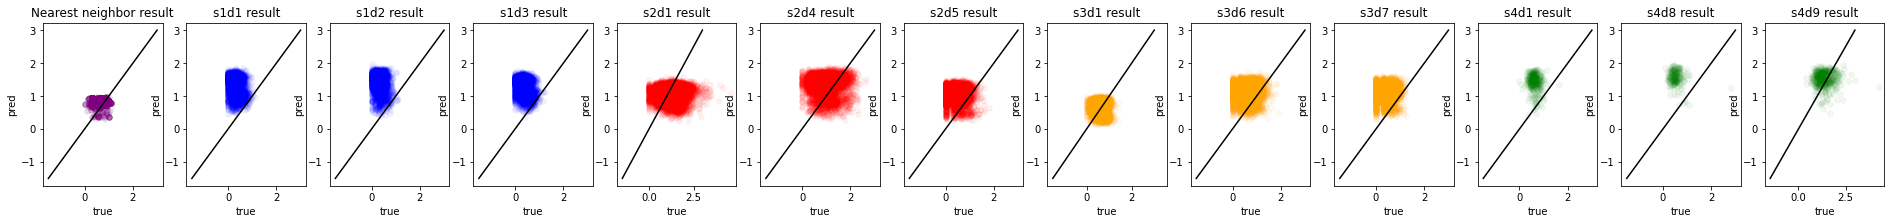

Epoch  100 near loss: 0.07889426 s1d1:  0.65146387 s1d2:  0.6407916 s1d3:  0.59698653 s2d1: 0.6989384 s2d4: 0.46439245 s2d5: 0.38743734 s3d1: 0.20398669 s3d6: 0.40932757 s3d7: 0.45368847 s4d1: 0.39568195 s4d8: 0.58975047 s4d9: 0.53030145 test loss: 0.5033567509989096
Epoch  200 near loss: 0.043536372 s1d1:  0.6593149 s1d2:  0.64416486 s1d3:  0.6064225 s2d1: 0.69218063 s2d4: 0.4675043 s2d5: 0.395387 s3d1: 0.20398213 s3d6: 0.42081136 s3d7: 0.46848154 s4d1: 0.39692727 s4d8: 0.5912409 s4d9: 0.52469313 test loss: 0.5013444532612871
Epoch  300 near loss: 0.030310625 s1d1:  0.66789544 s1d2:  0.6497076 s1d3:  0.615981 s2d1: 0.6851881 s2d4: 0.46978575 s2d5: 0.3995769 s3d1: 0.20420131 s3d6: 0.43123832 s3d7: 0.48356315 s4d1: 0.3988995 s4d8: 0.59217703 s4d9: 0.5222605 test loss: 0.5009299401493964
Epoch  400 near loss: 0.023172587 s1d1:  0.6713736 s1d2:  0.6518608 s1d3:  0.6202014 s2d1: 0.6806396 s2d4: 0.47146642 s2d5: 0.40292415 s3d1: 0.20420372 s3d6: 0.43817404 s3d7: 0.49306822 s4d1: 0.3995667 s

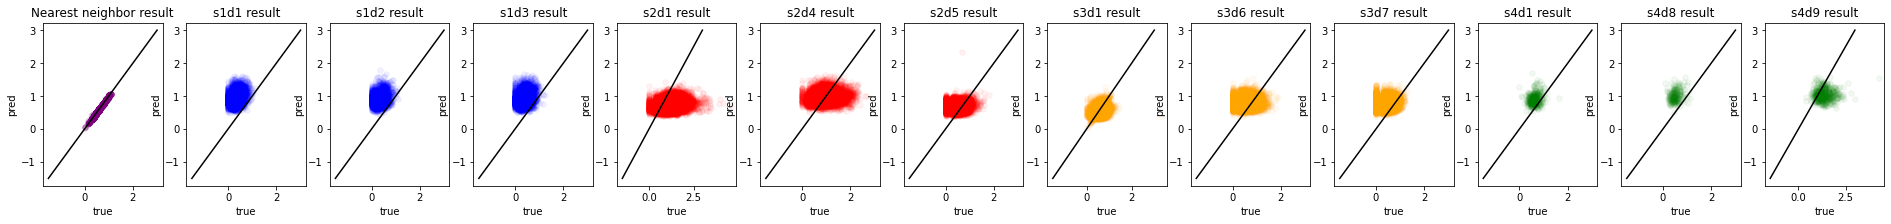

Epoch  1100 near loss: 0.0074755666 s1d1:  0.6466555 s1d2:  0.6209491 s1d3:  0.5970544 s2d1: 0.6819237 s2d4: 0.471684 s2d5: 0.39937395 s3d1: 0.20485198 s3d6: 0.4390572 s3d7: 0.49335843 s4d1: 0.3744424 s4d8: 0.55943185 s4d9: 0.5374848 test loss: 0.49417932607607234
Epoch  1200 near loss: 0.0066092173 s1d1:  0.6433958 s1d2:  0.6175132 s1d3:  0.5941259 s2d1: 0.6825144 s2d4: 0.47140408 s2d5: 0.3989918 s3d1: 0.20478979 s3d6: 0.4385065 s3d7: 0.49278888 s4d1: 0.37173498 s4d8: 0.5556007 s4d9: 0.53922313 test loss: 0.4934706277217897
Epoch  1300 near loss: 0.0059827985 s1d1:  0.6403256 s1d2:  0.61366814 s1d3:  0.5912648 s2d1: 0.6829396 s2d4: 0.47127977 s2d5: 0.39817882 s3d1: 0.20475055 s3d6: 0.43788272 s3d7: 0.49146113 s4d1: 0.3691507 s4d8: 0.55222654 s4d9: 0.5410884 test loss: 0.4929755714295186
Epoch  1400 near loss: 0.005500863 s1d1:  0.6383059 s1d2:  0.61122555 s1d3:  0.58966035 s2d1: 0.6831891 s2d4: 0.47111377 s2d5: 0.39800435 s3d1: 0.20476079 s3d6: 0.43758237 s3d7: 0.49083972 s4d1: 0.3672

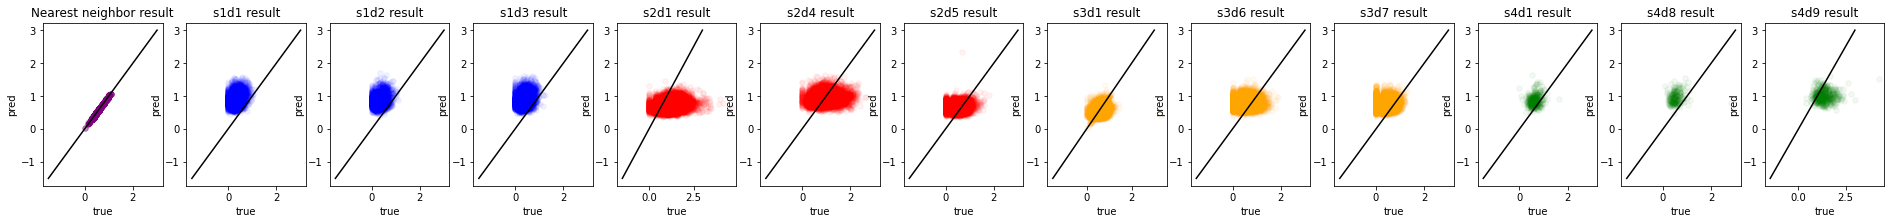

Epoch  2100 near loss: 0.003507552 s1d1:  0.61439216 s1d2:  0.58414197 s1d3:  0.56812835 s2d1: 0.69016707 s2d4: 0.4697583 s2d5: 0.39062932 s3d1: 0.2045471 s3d6: 0.42909566 s3d7: 0.47882643 s4d1: 0.3462985 s4d8: 0.5212564 s4d9: 0.5587826 test loss: 0.48950484630462215
Epoch  2200 near loss: 0.0034329158 s1d1:  0.60972095 s1d2:  0.57872295 s1d3:  0.56394374 s2d1: 0.6923311 s2d4: 0.46953708 s2d5: 0.38842356 s3d1: 0.20457986 s3d6: 0.42660552 s3d7: 0.47545314 s4d1: 0.3418984 s4d8: 0.51536787 s4d9: 0.56233567 test loss: 0.4890485027400344
Epoch  2300 near loss: 0.0031837572 s1d1:  0.60602593 s1d2:  0.57458353 s1d3:  0.5605476 s2d1: 0.693512 s2d4: 0.4695531 s2d5: 0.38721395 s3d1: 0.20454612 s3d6: 0.42527652 s3d7: 0.47345176 s4d1: 0.33888987 s4d8: 0.51143765 s4d9: 0.5650518 test loss: 0.48893198732213394
Epoch  2400 near loss: 0.0033245909 s1d1:  0.6010975 s1d2:  0.5696783 s1d3:  0.55603397 s2d1: 0.6956773 s2d4: 0.46942723 s2d5: 0.38551012 s3d1: 0.2044634 s3d6: 0.42305475 s3d7: 0.4705337 s4d1:

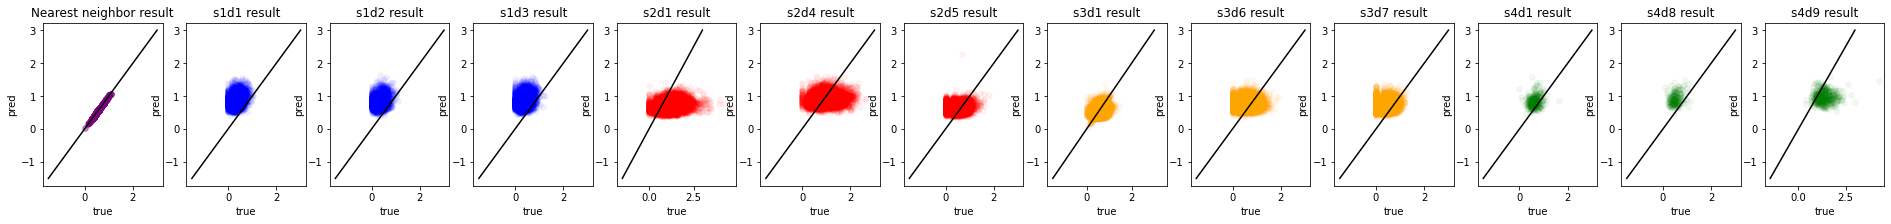

Epoch  3100 near loss: 0.002383174 s1d1:  0.5836938 s1d2:  0.5490231 s1d3:  0.5409734 s2d1: 0.7007515 s2d4: 0.46981308 s2d5: 0.37999034 s3d1: 0.20435354 s3d6: 0.41649565 s3d7: 0.46039298 s4d1: 0.319851 s4d8: 0.48492792 s4d9: 0.5822628 test loss: 0.4883253336880881
Epoch  3200 near loss: 0.002304637 s1d1:  0.5801552 s1d2:  0.5454076 s1d3:  0.537932 s2d1: 0.70214725 s2d4: 0.46986514 s2d5: 0.37888768 s3d1: 0.20430721 s3d6: 0.41495508 s3d7: 0.4582896 s4d1: 0.31705314 s4d8: 0.48120874 s4d9: 0.5847869 test loss: 0.4883387523819418
Epoch  3300 near loss: 0.002417248 s1d1:  0.5789008 s1d2:  0.54361826 s1d3:  0.5369593 s2d1: 0.70215774 s2d4: 0.46998498 s2d5: 0.37871245 s3d1: 0.20431761 s3d6: 0.4147089 s3d7: 0.45762026 s4d1: 0.31577516 s4d8: 0.4790948 s4d9: 0.5860164 test loss: 0.4883084458063581
Epoch  3400 near loss: 0.002161807 s1d1:  0.5746926 s1d2:  0.53915745 s1d3:  0.53292423 s2d1: 0.70400727 s2d4: 0.4701875 s2d5: 0.37708256 s3d1: 0.20426017 s3d6: 0.4127475 s3d7: 0.45494652 s4d1: 0.312403

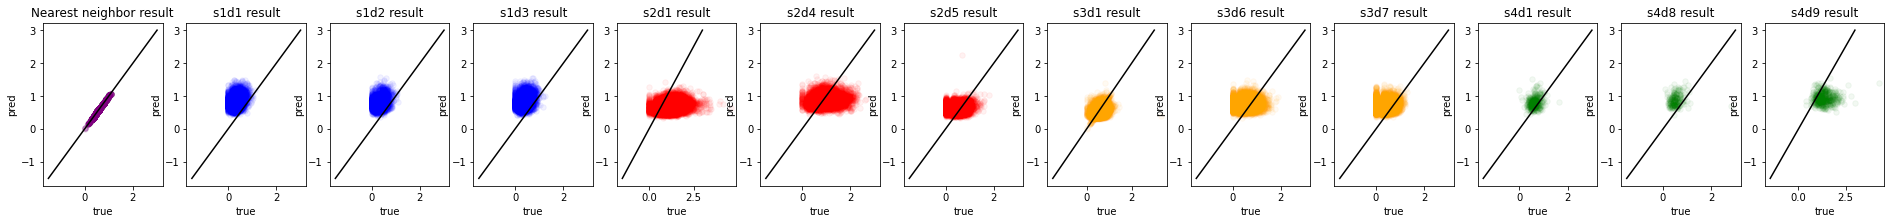

Epoch  4100 near loss: 0.002085643 s1d1:  0.5561656 s1d2:  0.5188954 s1d3:  0.5166595 s2d1: 0.7106354 s2d4: 0.4717108 s2d5: 0.37123466 s3d1: 0.20403804 s3d6: 0.4053955 s3d7: 0.44405296 s4d1: 0.29743606 s4d8: 0.45393014 s4d9: 0.6045307 test loss: 0.4898430263629539
Epoch  4200 near loss: 0.0021308064 s1d1:  0.55308867 s1d2:  0.5157011 s1d3:  0.514055 s2d1: 0.7119434 s2d4: 0.4720671 s2d5: 0.37024847 s3d1: 0.20403081 s3d6: 0.40409085 s3d7: 0.44206467 s4d1: 0.2951464 s4d8: 0.4505664 s4d9: 0.60704 test loss: 0.49016188438917657
Epoch  4300 near loss: 0.0020875614 s1d1:  0.5514129 s1d2:  0.5133981 s1d3:  0.5125744 s2d1: 0.71254826 s2d4: 0.4723164 s2d5: 0.3695811 s3d1: 0.20407805 s3d6: 0.40339923 s3d7: 0.44101074 s4d1: 0.2936501 s4d8: 0.4483402 s4d9: 0.60875726 test loss: 0.49041666058398814
Epoch  4400 near loss: 0.001793213 s1d1:  0.54973793 s1d2:  0.51171386 s1d3:  0.5113761 s2d1: 0.71284205 s2d4: 0.47246537 s2d5: 0.36945656 s3d1: 0.20403542 s3d6: 0.40300912 s3d7: 0.4401738 s4d1: 0.2924809

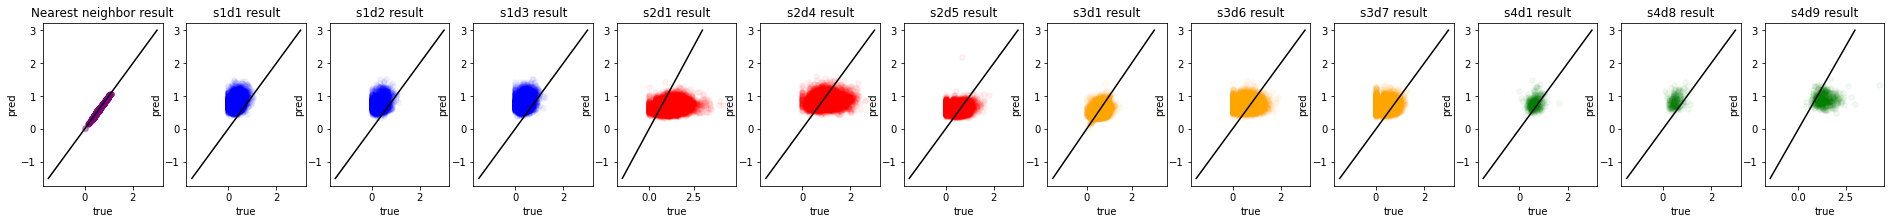

Epoch  5100 near loss: 0.0017513479 s1d1:  0.5343396 s1d2:  0.49416405 s1d3:  0.49772698 s2d1: 0.7187719 s2d4: 0.47483373 s2d5: 0.36427638 s3d1: 0.203988 s3d6: 0.39680037 s3d7: 0.43057206 s4d1: 0.28038952 s4d8: 0.42877498 s4d9: 0.62393767 test loss: 0.4929532547705452
Epoch  5200 near loss: 0.0016830822 s1d1:  0.5335054 s1d2:  0.49311227 s1d3:  0.49718058 s2d1: 0.7188977 s2d4: 0.47501087 s2d5: 0.36417323 s3d1: 0.2040147 s3d6: 0.39665335 s3d7: 0.43008837 s4d1: 0.2798529 s4d8: 0.42782456 s4d9: 0.62474525 test loss: 0.4931499159795161
Epoch  5300 near loss: 0.0016458142 s1d1:  0.5313639 s1d2:  0.4910459 s1d3:  0.49535835 s2d1: 0.71981466 s2d4: 0.4753385 s2d5: 0.36356184 s3d1: 0.20398033 s3d6: 0.39575234 s3d7: 0.42879564 s4d1: 0.27816427 s4d8: 0.4254715 s4d9: 0.6265416 test loss: 0.4934553934112008
Epoch  5400 near loss: 0.0016956981 s1d1:  0.5288341 s1d2:  0.48861802 s1d3:  0.4930386 s2d1: 0.72080153 s2d4: 0.47573906 s2d5: 0.36290768 s3d1: 0.20389676 s3d6: 0.3948307 s3d7: 0.4274629 s4d1: 

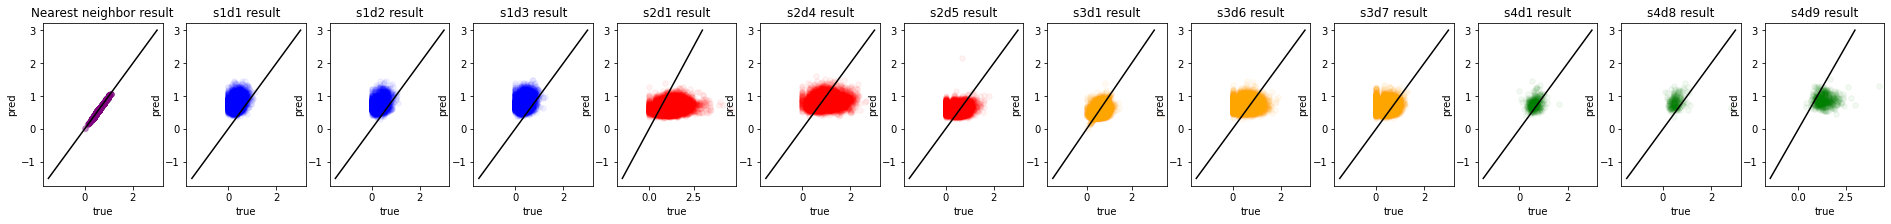

Epoch  6100 near loss: 0.001498861 s1d1:  0.51770765 s1d2:  0.4758629 s1d3:  0.4834307 s2d1: 0.7248859 s2d4: 0.47804192 s2d5: 0.35960606 s3d1: 0.20391464 s3d6: 0.3908049 s3d7: 0.4207569 s4d1: 0.26863077 s4d8: 0.4108031 s4d9: 0.6387572 test loss: 0.49629868916524433
Epoch  6200 near loss: 0.0014287655 s1d1:  0.5159924 s1d2:  0.47391778 s1d3:  0.48192525 s2d1: 0.7256439 s2d4: 0.47842684 s2d5: 0.3589945 s3d1: 0.20390482 s3d6: 0.39011368 s3d7: 0.41970554 s4d1: 0.2673765 s4d8: 0.4090003 s4d9: 0.64053434 test loss: 0.4968152747906368
Epoch  6300 near loss: 0.0013911577 s1d1:  0.51403016 s1d2:  0.47181535 s1d3:  0.48022953 s2d1: 0.72651297 s2d4: 0.47882053 s2d5: 0.35834438 s3d1: 0.2038878 s3d6: 0.38933924 s3d7: 0.418492 s4d1: 0.26606092 s4d8: 0.40693924 s4d9: 0.64239806 test loss: 0.49733326836164293
Epoch  6400 near loss: 0.0014246783 s1d1:  0.51333606 s1d2:  0.47099108 s1d3:  0.47973555 s2d1: 0.72680396 s2d4: 0.47903568 s2d5: 0.35822347 s3d1: 0.20394228 s3d6: 0.3890987 s3d7: 0.4179827 s4d1:

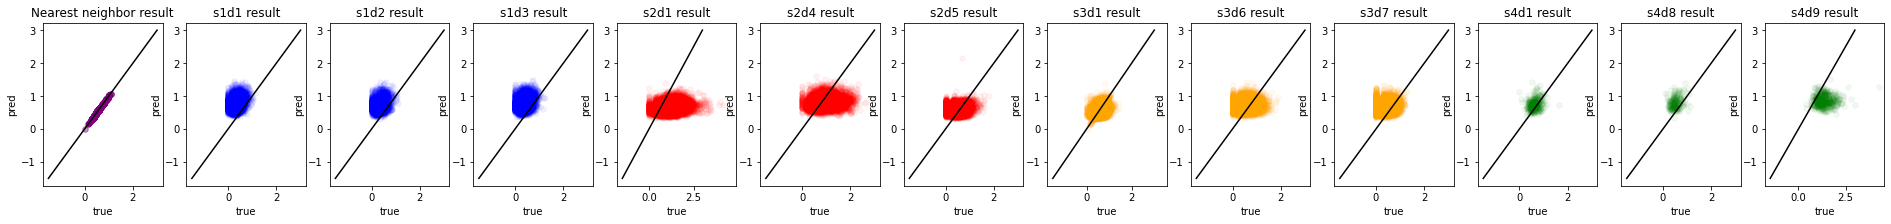

Epoch  7100 near loss: 0.0015264826 s1d1:  0.5020687 s1d2:  0.45824906 s1d3:  0.46996 s2d1: 0.73168415 s2d4: 0.48182744 s2d5: 0.35447574 s3d1: 0.20393404 s3d6: 0.38459122 s3d7: 0.4107675 s4d1: 0.25799716 s4d8: 0.39398983 s4d9: 0.6538606 test loss: 0.5006016934550032
Epoch  7200 near loss: 0.0012721127 s1d1:  0.5022944 s1d2:  0.45849597 s1d3:  0.4702792 s2d1: 0.73123825 s2d4: 0.48181883 s2d5: 0.35480174 s3d1: 0.20394188 s3d6: 0.38498187 s3d7: 0.41104838 s4d1: 0.25812525 s4d8: 0.3942746 s4d9: 0.65359193 test loss: 0.5005090910516306
Epoch  7300 near loss: 0.0014619125 s1d1:  0.5016817 s1d2:  0.45771083 s1d3:  0.46981117 s2d1: 0.73132855 s2d4: 0.48192137 s2d5: 0.35469037 s3d1: 0.20392765 s3d6: 0.3848773 s3d7: 0.41084155 s4d1: 0.25784546 s4d8: 0.3937671 s4d9: 0.6540171 test loss: 0.500633129956933
Epoch  7400 near loss: 0.0015395306 s1d1:  0.50105983 s1d2:  0.45681205 s1d3:  0.46941856 s2d1: 0.73150563 s2d4: 0.48211065 s2d5: 0.3545742 s3d1: 0.20396478 s3d6: 0.3845441 s3d7: 0.41024798 s4d1:

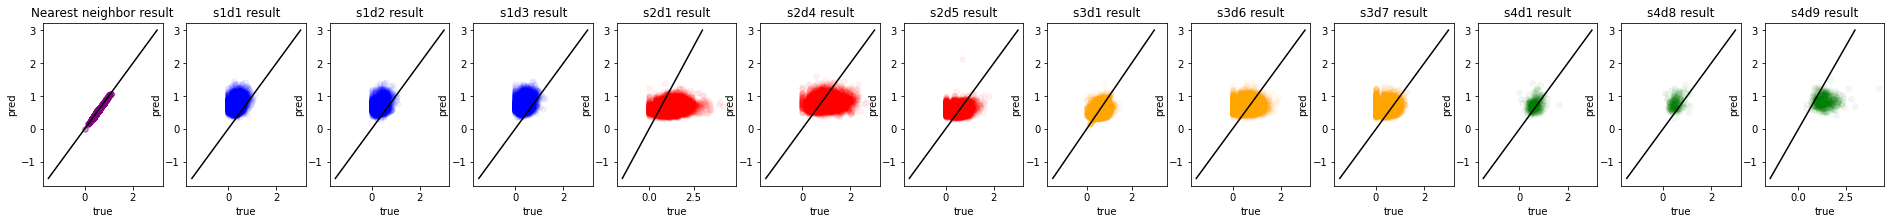

Epoch  8100 near loss: 0.0014037557 s1d1:  0.4915566 s1d2:  0.44616586 s1d3:  0.46097955 s2d1: 0.735724 s2d4: 0.48482826 s2d5: 0.3513636 s3d1: 0.203986 s3d6: 0.3809069 s3d7: 0.40425992 s4d1: 0.25112024 s4d8: 0.3826346 s4d9: 0.66430384 test loss: 0.5039104306247193
Epoch  8200 near loss: 0.0012146456 s1d1:  0.49149087 s1d2:  0.4461353 s1d3:  0.4610504 s2d1: 0.7357319 s2d4: 0.48485348 s2d5: 0.35155693 s3d1: 0.20396644 s3d6: 0.3809249 s3d7: 0.40414622 s4d1: 0.25117272 s4d8: 0.3826803 s4d9: 0.6642955 test loss: 0.5039213029845725
Epoch  8300 near loss: 0.0013872279 s1d1:  0.48968974 s1d2:  0.44414717 s1d3:  0.45945802 s2d1: 0.7366204 s2d4: 0.4854195 s2d5: 0.3508446 s3d1: 0.20397732 s3d6: 0.3801785 s3d7: 0.40294 s4d1: 0.24992214 s4d8: 0.38063055 s4d9: 0.66620815 test loss: 0.5045508528776439
Epoch  8400 near loss: 0.0011742819 s1d1:  0.48948234 s1d2:  0.4441759 s1d3:  0.45934796 s2d1: 0.7363302 s2d4: 0.4853841 s2d5: 0.3511674 s3d1: 0.20388667 s3d6: 0.3804001 s3d7: 0.40319416 s4d1: 0.2500866

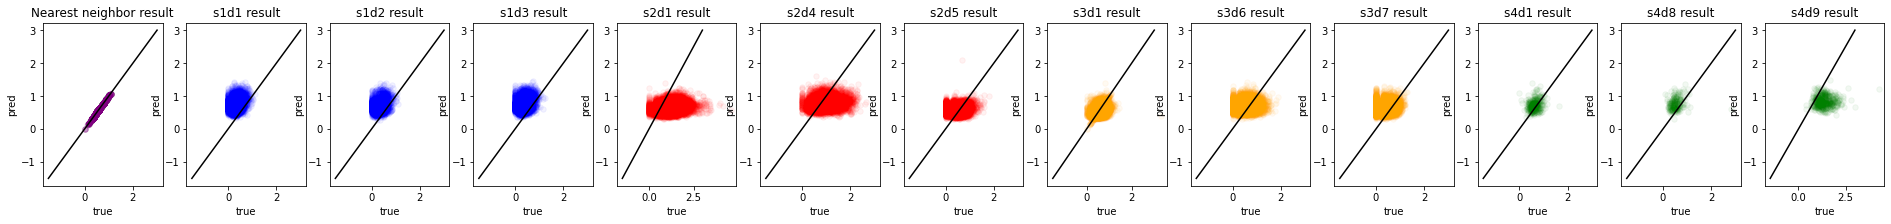

Epoch  9100 near loss: 0.0011217133 s1d1:  0.48373407 s1d2:  0.43760616 s1d3:  0.45440814 s2d1: 0.73876274 s2d4: 0.48721874 s2d5: 0.34934545 s3d1: 0.20389208 s3d6: 0.3781871 s3d7: 0.39951596 s4d1: 0.24641383 s4d8: 0.37472886 s4d9: 0.67177445 test loss: 0.5064441163637017
Epoch  9200 near loss: 0.0011249982 s1d1:  0.48299074 s1d2:  0.4366598 s1d3:  0.45393696 s2d1: 0.73907655 s2d4: 0.4874829 s2d5: 0.34916973 s3d1: 0.20393206 s3d6: 0.37786782 s3d7: 0.3989853 s4d1: 0.24597965 s4d8: 0.37379748 s4d9: 0.67264193 test loss: 0.506759545355542
Epoch  9300 near loss: 0.0015152512 s1d1:  0.4818113 s1d2:  0.43568665 s1d3:  0.452746 s2d1: 0.73964196 s2d4: 0.48779672 s2d5: 0.34879816 s3d1: 0.20384175 s3d6: 0.37735376 s3d7: 0.39837322 s4d1: 0.24519889 s4d8: 0.3727613 s4d9: 0.6736685 test loss: 0.5071009746684981
Epoch  9400 near loss: 0.0011577574 s1d1:  0.48193866 s1d2:  0.43540293 s1d3:  0.45299822 s2d1: 0.7394206 s2d4: 0.48782456 s2d5: 0.34876975 s3d1: 0.20391923 s3d6: 0.37754068 s3d7: 0.3983774 s

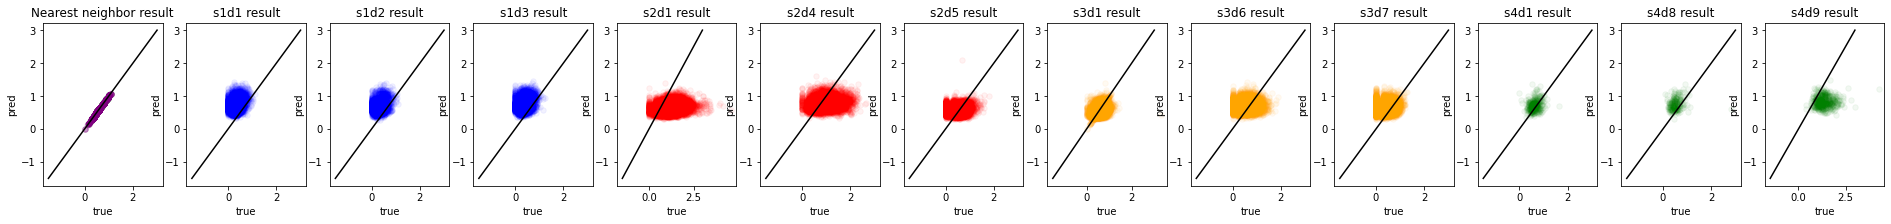

Epoch  10100 near loss: 0.0010218623 s1d1:  0.47739378 s1d2:  0.4302869 s1d3:  0.44918987 s2d1: 0.7414199 s2d4: 0.48931715 s2d5: 0.34748623 s3d1: 0.20391771 s3d6: 0.37589547 s3d7: 0.39555347 s4d1: 0.24255723 s4d8: 0.36798206 s4d9: 0.67859906 test loss: 0.508968149454996
Epoch  10200 near loss: 0.0012134124 s1d1:  0.47616896 s1d2:  0.42907938 s1d3:  0.44801173 s2d1: 0.74201614 s2d4: 0.48972127 s2d5: 0.3470995 s3d1: 0.20386548 s3d6: 0.3753887 s3d7: 0.39477846 s4d1: 0.24187094 s4d8: 0.36693636 s4d9: 0.67971337 test loss: 0.5093851034575377
Epoch  10300 near loss: 0.0014159853 s1d1:  0.47551948 s1d2:  0.4282175 s1d3:  0.447561 s2d1: 0.7423597 s2d4: 0.489932 s2d5: 0.34681872 s3d1: 0.2038674 s3d6: 0.37501743 s3d7: 0.39433113 s4d1: 0.24145737 s4d8: 0.36601818 s4d9: 0.6805361 test loss: 0.509686945919891
Epoch  10400 near loss: 0.0010735652 s1d1:  0.47510585 s1d2:  0.4279067 s1d3:  0.4472863 s2d1: 0.7423815 s2d4: 0.49006864 s2d5: 0.34695014 s3d1: 0.20385183 s3d6: 0.37507388 s3d7: 0.39412695 s4

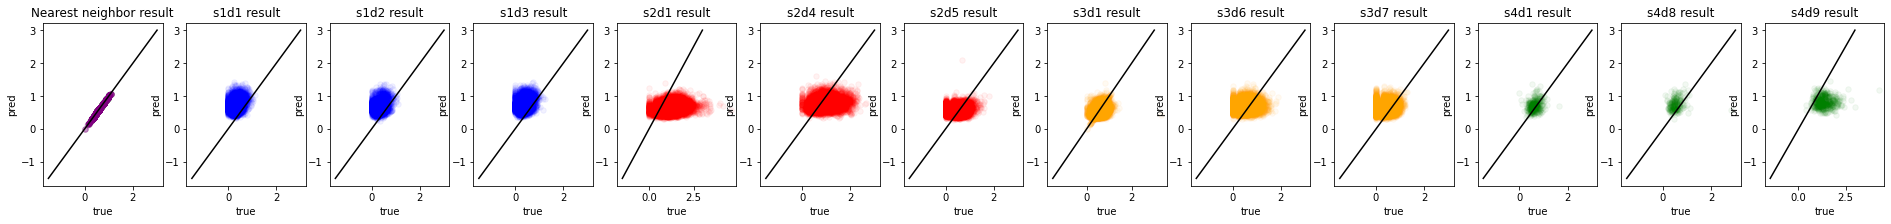

Epoch  11100 near loss: 0.0012042559 s1d1:  0.47300023 s1d2:  0.42509508 s1d3:  0.4458238 s2d1: 0.74299896 s2d4: 0.49090913 s2d5: 0.34638748 s3d1: 0.20393784 s3d6: 0.37441334 s3d7: 0.39286062 s4d1: 0.2400368 s4d8: 0.36312672 s4d9: 0.6832751 test loss: 0.5107156726234665
Epoch  11200 near loss: 0.0009908507 s1d1:  0.47097132 s1d2:  0.4231193 s1d3:  0.44377673 s2d1: 0.7441196 s2d4: 0.4915441 s2d5: 0.3456665 s3d1: 0.20385246 s3d6: 0.37366143 s3d7: 0.39164025 s4d1: 0.23910464 s4d8: 0.36164853 s4d9: 0.6849386 test loss: 0.511374862449537
Epoch  11300 near loss: 0.0012063738 s1d1:  0.47035068 s1d2:  0.42228493 s1d3:  0.4432686 s2d1: 0.74444395 s2d4: 0.49180523 s2d5: 0.34539288 s3d1: 0.2038659 s3d6: 0.37329525 s3d7: 0.39114934 s4d1: 0.23862243 s4d8: 0.36062616 s4d9: 0.6859218 test loss: 0.5117549192371407
Epoch  11400 near loss: 0.001167867 s1d1:  0.4706519 s1d2:  0.42284948 s1d3:  0.4436994 s2d1: 0.7440093 s2d4: 0.49163345 s2d5: 0.34582737 s3d1: 0.20382881 s3d6: 0.3737156 s3d7: 0.39164436 s4

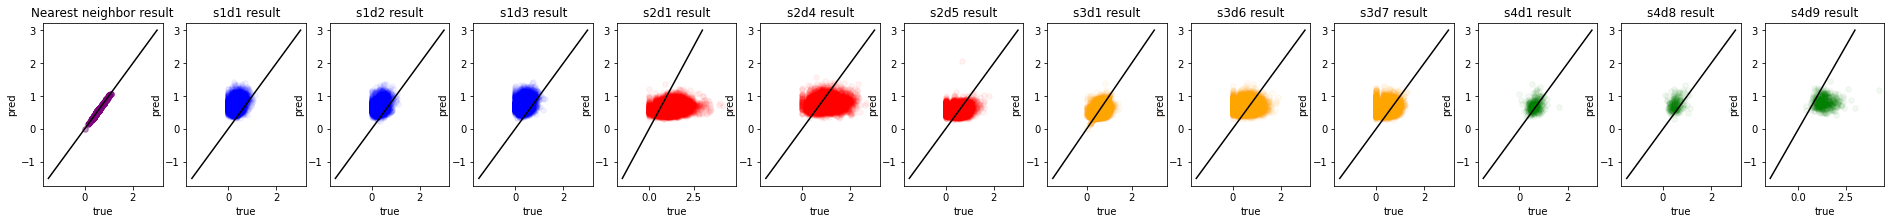

Epoch  12100 near loss: 0.0010537445 s1d1:  0.46666968 s1d2:  0.41807178 s1d3:  0.44033906 s2d1: 0.7459687 s2d4: 0.4931946 s2d5: 0.34440807 s3d1: 0.20388898 s3d6: 0.371993 s3d7: 0.3888529 s4d1: 0.23669587 s4d8: 0.35683343 s4d9: 0.6898035 test loss: 0.5132982592108698


RuntimeError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 47.54 GiB total capacity; 9.70 GiB already allocated; 242.75 MiB free; 10.16 GiB reserved in total by PyTorch)

In [41]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)